## Setup: Libraries & Configuration

## 11. Compare Baseline, Linear, and Tuned Models

This step compares the performance of a baseline model, a standard linear regression, and the best model obtained through grid search.  
All models are evaluated using cross-validation with consistent preprocessing steps.

In [52]:
# Libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose

# Project paths
from src.config import RAW_DATA, CLEAN_DATA, FEATURES_DATA

# Visualization settings
from src.visualization import (
PALETTE,
SCATTER_ALPHA
)

# Global seaborn theme
sns.set_theme(style="whitegrid", palette="bright")

# Images
IMG_DIR = Path.cwd().parent / "reports" / "images"
IMG_DIR.mkdir(parents=True, exist_ok=True)



## 1. Load DataFrame

In [53]:
df_raw = pd.read_csv(RAW_DATA)
display(df_raw.tail())

,Date,boc1,smc1,so-premp-c1,sm-premp-c1,sc1,rin-d4-us,lcoc1,clc1,hoc1,...,bo-brzpar-a1,palm-mycrd-p1,soy-arg-ref,jci-hogm-fujn,jci-hogm-shai,palm-sea-ocrdm,soil-sea-dgcf,sunf-sea-crm,go10sgswmc1,rbd-pko-m1
3426,2025-04-10,46.32,297.9,200.0,1.0,1029.00,103.50,63.33,60.07,2.0464,...,1032.2,1330.0,31.48,24.0,-72.0,1120.0,1110.0,1220.0,78.51,1940.0
3427,2025-04-11,47.35,299.6,-230.0,2.0,1042.75,106.00,64.76,61.50,2.0653,...,1021.8,1330.0,35.05,24.0,-72.0,1120.0,1148.0,1220.0,78.05,1945.0
3428,2025-04-14,46.32,297.1,50.0,3.0,1041.75,103.75,64.88,61.53,2.0917,...,1043.2,1330.0,16.68,24.0,-24.0,1125.0,1102.0,1220.0,79.47,1950.0
3429,2025-04-15,47.33,294.2,50.0,6.0,1036.00,103.75,64.67,61.33,2.0784,...,1065.5,1320.0,20.71,48.0,-24.0,1115.0,1100.0,1210.0,80.06,1945.0
3430,2025-04-16,47.41,296.7,150.0,NaN,1037.75,NaN,65.85,62.60,2.1203,...,NaN,1320.0,22.47,48.0,-24.0,1100.0,1100.0,1210.0,80.87,1970.0


## 2. Dataset Shape & Info

In [54]:
print("Shape:", df_raw.shape)
print("-" * 40)
display(df_raw.info())


Shape: (3431, 31)
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            3431 non-null   object 
 1   boc1            3000 non-null   float64
 2   smc1            3000 non-null   float64
 3   so-premp-c1     3000 non-null   float64
 4   sm-premp-c1     3000 non-null   float64
 5   sc1             3000 non-null   float64
 6   rin-d4-us       2456 non-null   float64
 7   lcoc1           3000 non-null   float64
 8   clc1            3000 non-null   float64
 9   hoc1            3000 non-null   float64
 10  cc1             3000 non-null   float64
 11  brl=            3000 non-null   float64
 12  fcpoc1          3000 non-null   float64
 13  fupoc1          3000 non-null   float64
 14  rsc1            3000 non-null   float64
 15  myr=            3000 non-null   float64
 16  cpo-id-m1       300

None

## 3. Missing Values Check

In [55]:
missing_counts = df_raw.isna().sum().sort_values(ascending=False)
display(missing_counts.to_frame(name="missing_count"))

,missing_count
go10sgswmc1,1653
rin-d4-us,975
palm-mycrd-p1,432
sm-premp-c1,431
so-premp-c1,431
smc1,431
boc1,431
brl=,431
clc1,431
hoc1,431


## 4. Descriptive statistics

In [56]:
display(df_raw.describe().round(2))

,boc1,smc1,so-premp-c1,sm-premp-c1,sc1,rin-d4-us,lcoc1,clc1,hoc1,cc1,...,bo-brzpar-a1,palm-mycrd-p1,soy-arg-ref,jci-hogm-fujn,jci-hogm-shai,palm-sea-ocrdm,soil-sea-dgcf,sunf-sea-crm,go10sgswmc1,rbd-pko-m1
count,3000.00,3000.00,3000.00,3000.00,3000.00,2456.00,3000.00,3000.00,3000.00,3000.00,...,3000.00,2999.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,1778.00,3000.00
mean,41.53,360.60,-49.97,5.49,1135.21,91.96,70.69,66.79,2.19,448.11,...,914.79,866.85,51.63,496.97,475.09,847.36,979.50,1020.76,88.96,1202.21
std,13.94,62.66,466.03,20.98,242.55,43.74,21.02,20.71,0.71,116.80,...,265.50,291.88,24.98,817.84,774.06,273.69,266.33,275.31,25.76,407.60
min,24.99,257.20,-2380.00,-35.00,791.00,30.00,19.33,-37.63,0.61,301.50,...,567.90,440.00,-464.76,-492.00,-487.20,455.00,630.00,680.00,25.65,620.00
25%,31.23,308.08,-21.00,-11.00,934.00,55.75,54.67,50.36,1.65,364.50,...,711.85,660.00,38.30,0.00,20.00,655.00,773.00,822.00,75.38,920.00
50%,34.79,339.95,9.00,4.00,1031.12,80.50,69.88,65.78,2.09,397.38,...,837.65,790.00,50.76,216.00,200.00,795.00,910.00,915.00,87.78,1095.00
75%,48.11,412.30,150.00,18.00,1344.44,112.25,83.28,80.11,2.71,492.06,...,1039.70,1015.00,64.81,640.00,600.00,980.00,1120.00,1200.00,101.84,1400.00
max,90.60,535.50,1000.00,105.00,1769.00,204.00,127.98,123.70,5.14,818.25,...,2096.60,2010.00,182.49,3498.00,3128.00,2010.00,2078.00,2300.00,178.39,2800.00


## 5. Column selection

In [57]:
cols = ['Date', 'boc1', 'smc1', 'sc1', 'lcoc1', 'hoc1', 'fcpoc1', 'rsc1']
df = df_raw[cols].copy()
df = df.sort_values(by='Date', ascending=False)
display(df.head())

,Date,boc1,smc1,sc1,lcoc1,hoc1,fcpoc1,rsc1
3430,2025-04-16,47.41,296.7,1037.75,65.85,2.1203,4207.0,673.8
3429,2025-04-15,47.33,294.2,1036.00,64.67,2.0784,4320.0,668.9
3428,2025-04-14,46.32,297.1,1041.75,64.88,2.0917,4354.0,661.6
3427,2025-04-11,47.35,299.6,1042.75,64.76,2.0653,4461.0,660.7
3426,2025-04-10,46.32,297.9,1029.00,63.33,2.0464,4444.0,654.0


## 6. Drop missing values

In [58]:
initial_rows = df.shape[0]

df = df.dropna().reset_index(drop=True)

print(f"Dropped {initial_rows - df.shape[0]} rows; new shape: {df.shape}")

df.info()

Dropped 735 rows; new shape: (2696, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2696 entries, 0 to 2695
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2696 non-null   object 
 1   boc1    2696 non-null   float64
 2   smc1    2696 non-null   float64
 3   sc1     2696 non-null   float64
 4   lcoc1   2696 non-null   float64
 5   hoc1    2696 non-null   float64
 6   fcpoc1  2696 non-null   float64
 7   rsc1    2696 non-null   float64
dtypes: float64(7), object(1)
memory usage: 168.6+ KB


## 7. Date Conversion & Indexing

In [59]:
df = df.rename(columns={'Date': 'date'})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

## 8. Feature Engineering: Adding New Columns

In [60]:
# 1) Temporal features
df['month'] = df.index.month

# 2) Quick overview
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2696 entries, 2013-09-03 to 2025-04-16
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   boc1    2696 non-null   float64
 1   smc1    2696 non-null   float64
 2   sc1     2696 non-null   float64
 3   lcoc1   2696 non-null   float64
 4   hoc1    2696 non-null   float64
 5   fcpoc1  2696 non-null   float64
 6   rsc1    2696 non-null   float64
 7   month   2696 non-null   int32  
dtypes: float64(7), int32(1)
memory usage: 179.0 KB


## 9. Skewness and Kurtosis

**Skewness** measures the asymmetry of a distribution around its mean.  
– Positive skew (“long right tail”) → a few unusually large values  
– Negative skew (“long left tail”) → a few unusually small values  
– Near 0 → fairly symmetric

**Kurtosis** measures the tailedness of a distribution (Fisher’s excess kurtosis, so normal = 0).  
– Positive → heavy tails / sharper peak (more extremes)  
– Negative → light tails / flatter peak (fewer extremes)

In [61]:
num_df = df.select_dtypes(include="number")
display(num_df.skew().to_frame("skewness"))
print("-" * 60)
display(num_df.kurtosis().to_frame("kurtosis"))

,skewness
boc1,1.131361
smc1,0.616216
sc1,0.695464
lcoc1,0.310928
hoc1,0.633419
fcpoc1,1.262453
rsc1,1.402606
month,-0.009187


------------------------------------------------------------


,kurtosis
boc1,0.289307
smc1,-0.780449
sc1,-0.755404
lcoc1,-0.484956
hoc1,0.242719
fcpoc1,1.579288
rsc1,1.102791
month,-1.256376


## 10. Pairplot of Key Features

A **PairPlot** shows:

- **Scatterplots** of every pair of variables (off‑diagonal), helping you spot linear or nonlinear relationships, clusters, and outliers.
- **Univariate distributions** (diagonal), here as kernel density estimates (`kde`), so you can check each feature’s shape at a glance.
- **Transparency** (`alpha`) to reveal overlapping points.

Since we’ve already narrowed down to the top 5 features most correlated with `boc1`, this pairplot gives a clear, manageable view of how our target and key predictors interact.

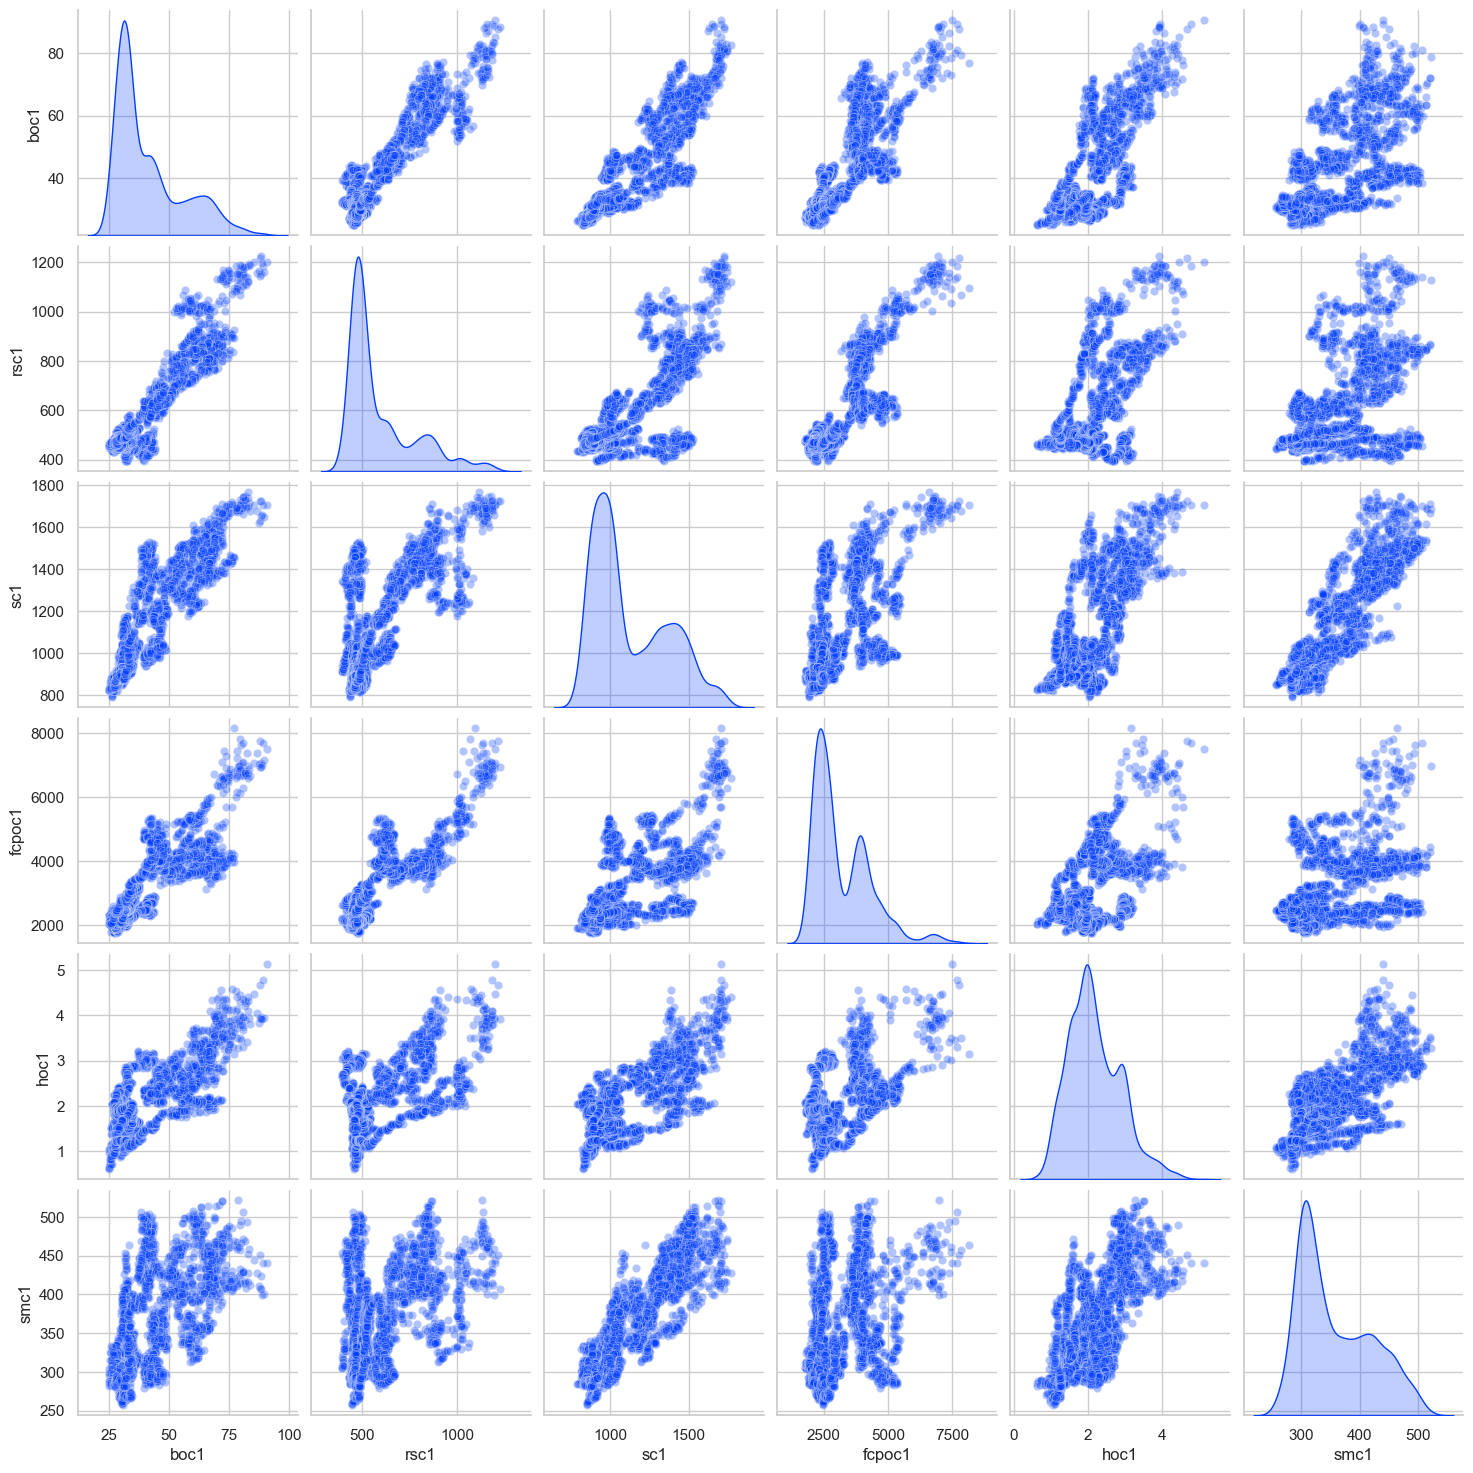

In [ ]:
top_feats = (
    df.corr()
      .abs()['boc1']
      .sort_values(ascending=False)
      .index[1:6]
      .tolist()
)

g = sns.pairplot(
    df[['boc1'] + top_feats],
    diag_kind="kde",
    plot_kws={'alpha': 0.3}
)

g.figure.savefig(IMG_DIR / "pairplot.png", dpi=150, bbox_inches='tight')

## 11. Boxplot Analysis

**Boxplots** (also called **box‑and‑whisker plots**) provide a compact visual summary of a continuous distribution by showing:

- **Median**: the central line in the box (50th percentile).  
- **Quartiles**: the edges of the box represent Q1 (25th percentile) and Q3 (75th percentile).  
- **Interquartile Range (IQR)**: the height of the box (Q3 – Q1), capturing the middle 50% of values.  
- **Whiskers**: lines extending to the most extreme data points within 1.5 × IQR from the quartiles.  
- **Outliers**: individual points beyond the whiskers, highlighting unusually large or small values.  
- **Mean (optional)**: when `showmeans=True`, a marker indicates the average value.

Boxplots make it easy to compare central tendency, spread, skewness, and outliers across multiple float features at a glance.

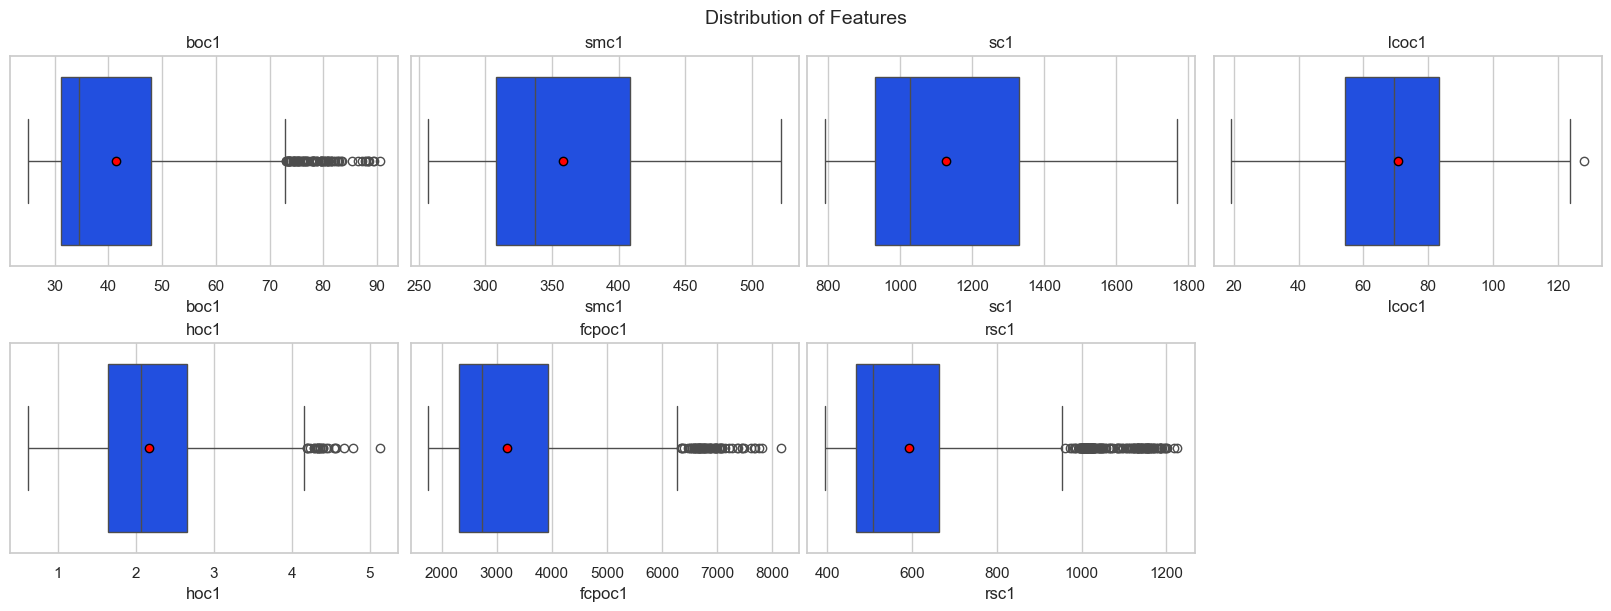

In [63]:
# Select only float columns
float_cols = df.select_dtypes(include=['float']).columns.tolist()

# Compute grid size
n_feats = len(float_cols)
n_cols = 4
n_rows = math.ceil(n_feats / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 4, n_rows * 3),
    constrained_layout=True
)

# Flatten axes array and plot
for ax, col in zip(axes.flatten(), float_cols):
    sns.boxplot(
        data=df,
        x=col,
        ax=ax,
        showmeans=True,
        meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black"},
    )
    ax.set_title(col)


# Hide any unused subplots
for ax in axes.flatten()[n_feats:]:
    ax.set_visible(False)

# Title
fig.suptitle("Distribution of Features", fontsize=14)

plt.show()
fig.savefig("../reports/images/boxplot_all_vars.png", dpi=150, bbox_inches='tight')

## 12. Correlation Heatmap

A **correlation matrix** shows the strength and direction of the linear relationship between each pair of numerical features:

- **Values range from –1 to +1**  
  - **+1** indicates a perfect positive correlation (both features increase together).  
  - **–1** indicates a perfect negative correlation (one increases while the other decreases).  
  - **0** indicates no linear relationship.

- **Magnitude** tells you how strongly two variables move together.  
- **Sign** tells you the direction of that relationship (positive or negative).

By visualizing these correlations as a heatmap—and masking the redundant half—we can quickly spot which variables are most strongly associated (dark/high-magnitude cells) and identify potential multicollinearity or key predictors for our regression model. 

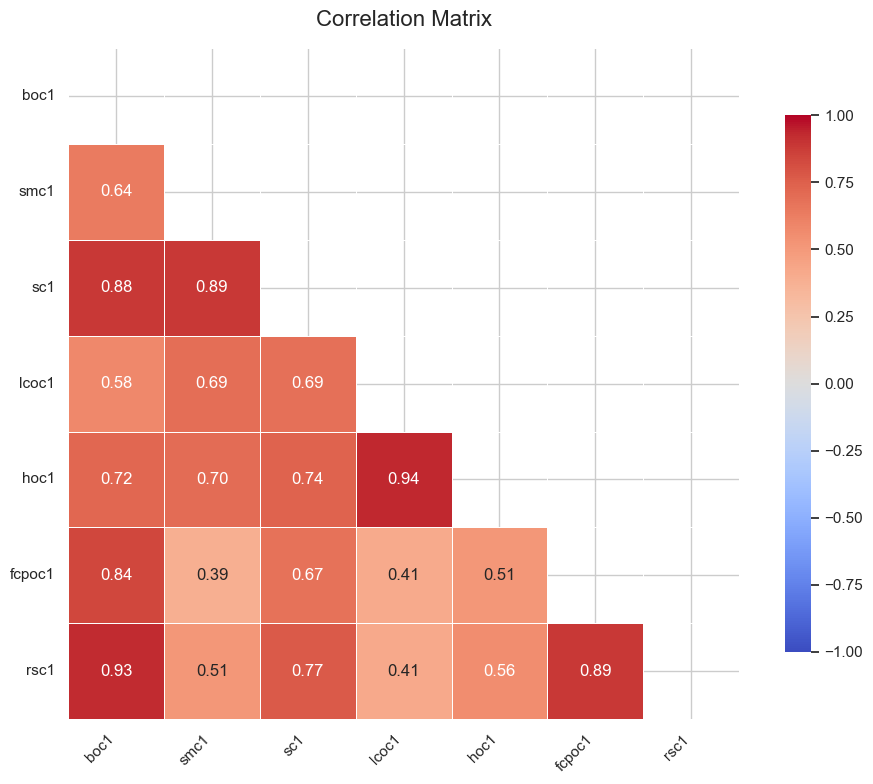

In [64]:
# 1) Correlation Matrix
float_df = df.select_dtypes(include=['float'])
corr = float_df.corr()

# 2) Mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# 3) Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=PALETTE,
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)

# 4) Final adjustments
ax.set_title("Correlation Matrix", fontsize=16, pad=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

fig.savefig("../reports/images/heatmap_corr.png", dpi=150, bbox_inches='tight')

## 13. Multicollinearity Check: VIF

In [65]:
# 1) Prepare the design matrix (only float predictors)
X = df.select_dtypes(include=['float']).copy()

# 2) Add intercept (required by statsmodels)
X['intercept'] = 1.0

# 3) Compute VIF for each feature
vif_data = []
for i, col in enumerate(X.columns):
    vif = variance_inflation_factor(X.values, i)
    vif_data.append((col, vif))

# 4) Build a sorted DataFrame
vif_df = pd.DataFrame(vif_data, columns=['feature', 'VIF']) \
            .sort_values('VIF', ascending=False) \
            .reset_index(drop=True)

display(vif_df)

,feature,VIF
0,intercept,47.418728
1,sc1,34.866253
2,boc1,34.766438
3,hoc1,19.945857
4,lcoc1,14.338782
5,smc1,12.828950
6,rsc1,12.439722
7,fcpoc1,5.736464


## 14. Time-Series Trends & Seasonality of the Target

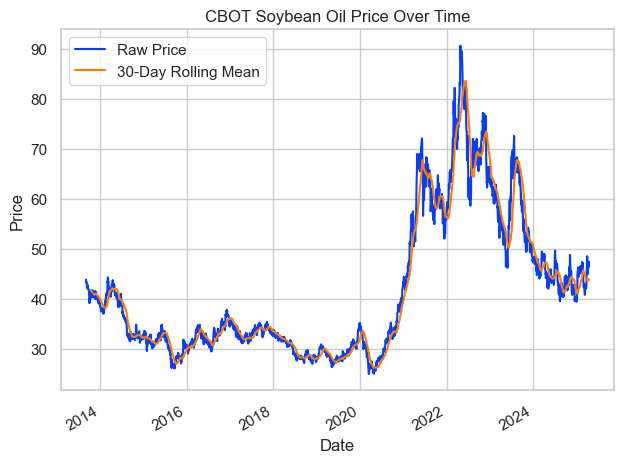

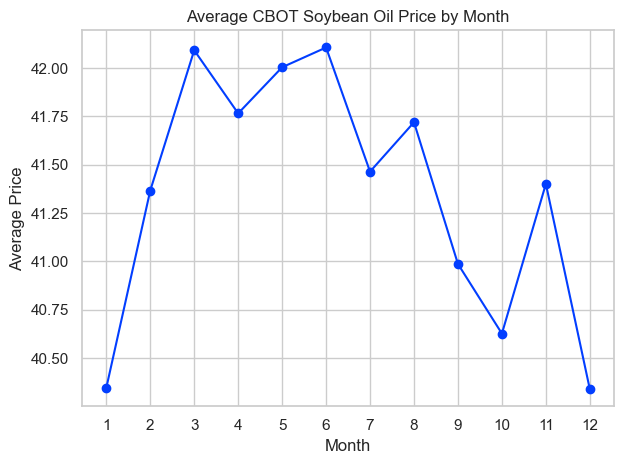

In [66]:
# 1) Time‑Series Line Plot with Rolling Mean
fig, ax = plt.subplots()
df['boc1'].plot(label='Raw Price', ax=ax)
df['boc1'].rolling(window=30).mean().plot(label='30-Day Rolling Mean', ax=ax)

ax.set_title('CBOT Soybean Oil Price Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
fig.tight_layout()
fig.savefig("../reports/images/rolling_avg_boc1.png", dpi=150, bbox_inches='tight')


# 2) Seasonality Plot: Average Price by Month
monthly_avg = df['boc1'].groupby(df.index.month).mean()
plt.figure()
monthly_avg.plot(marker='o')
plt.title('Average CBOT Soybean Oil Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()


## 15. Time‑Series Decomposition

The **seasonal decomposition** splits our time series into four components:

- **Observed**: the original data series.  
- **Trend**: the long‑term progression, highlighting upward or downward movements over time.  
- **Seasonal**: the repeating pattern on an annual cycle (here ~252 trading days), showing regular peaks and troughs.  
- **Residual**: the remaining “noise” after removing trend and seasonality, smoothed with a 30‑day moving average to reduce volatility.

This decomposition helps us understand how much of the price movement is driven by underlying trends, recurring seasonal effects, and irregular fluctuations, guiding preprocessing and model design.

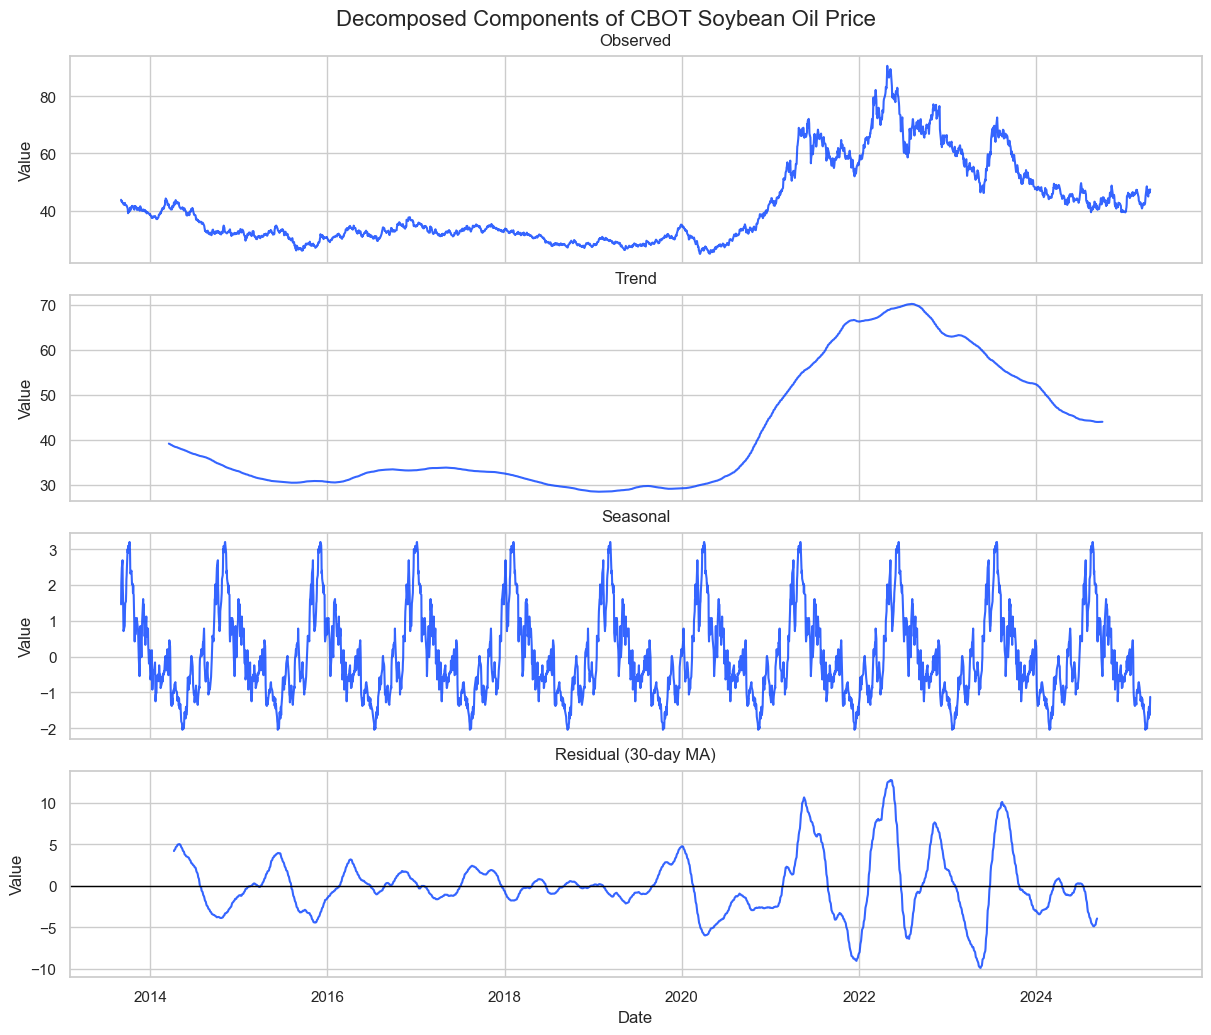

In [67]:
# 1) Decompose the series (annual seasonality ≈ 252 trading days)
decomp = seasonal_decompose(df['boc1'], model='additive', period=252)

# 2) Extract components
components = {
    'Observed': decomp.observed,
    'Trend': decomp.trend,
    'Seasonal': decomp.seasonal,
    'Residual (30-day MA)': decomp.resid.rolling(window=30, center=True).mean()
}

# 3) Plot each component
fig, axes = plt.subplots(len(components), 1, figsize=(12, 10), sharex=True, constrained_layout=True)
for ax, (name, series) in zip(axes, components.items()):
    sns.lineplot(x=series.index, y=series.values, ax=ax, alpha=0.8, linewidth=1.5)
    ax.set_title(name, fontsize=12, pad=8)
    if 'Residual' in name:
        ax.axhline(0, color='black', linewidth=1)
    ax.set_ylabel('Value')
axes[-1].set_xlabel('Date')
fig.suptitle('Decomposed Components of CBOT Soybean Oil Price', fontsize=16, y=1.02)
plt.show()

## 16. Saving the cleaned data

In [68]:
df_clean = df
df_clean.to_parquet(CLEAN_DATA, index=True)
df_clean.drop(columns="month").describe().to_csv(FEATURES_DATA)